# CTPN+CRNN 算法端到端实现文字识别

## OCR介绍
光学字符识别（英语：Optical Character Recognition，OCR）是指对文本资料的图像文件进行分析识别处理，获取文字及版面信息的过程。发展时间较长，使用很普遍。OCR作为计算机视觉中较早使用深度学习技术的领域，有很多优秀的模型出现。普遍的深度学习下的OCR技术将文字识别过程分为：文本区域检测以及字符识别。

## 文本区域检测——CTPN模型
文字区域检测：将图片中出现的文本位置检测出来，可能存在不同语言，不同文字大小，不同角度倾斜，不同程度遮挡等情况。 
CTPN网络结合了CNN与LSTM深度网络，通过固定宽度的anchor提取proposal，能有效的检测出复杂场景的横向分布的文字区域，不定长度文本识别效果较好，是目前使用广泛的文字检测算法。
![jupyter](./imgs/1.png)

## 字符序列检测——CRNN模型
字符识别算法：将文本区域的字符识别出来。通过深度神经网络对目标区域进行特征提取，然后对固定特征进行提取和比对，得出识别结果。
采用文本识别网络CRNN+CTC。CRNN全称为卷积循环神经网络，将特征提取，序列建模以及转录整合到统一的模型框架中。主要用于端到端地对不定长的文本序列进行识别，不用先对单个文字进行切割，而是将文本识别转化为时序依赖的序列学习问题，就是基于图像的序列识别。
如下图，CRNN网络分为：卷积层、循环层和转录层三部分，CTC为无词典的转录方式， 不会被局限在预定义词汇范围中。 
![jupyter](./imgs/2.png)

## 完整的端到端OCR流程
了解了文本区域检测以及字符识别后，下面详细讲解完整的端到端OCR流程：
![jupyter](./imgs/3.png)

（1）准备一张含有文字的原图； 

（2）对原图进行文字位置的检测，检测结果可能是水平矩形框，也可能是倾斜矩形框；

（3）从原图中把文字框对应的图片切下来，并旋转正，得到水平的文字块切片图； 

（4）对每个文字块切片图依次进行字符识别，每个切片图的识别结果汇总起来，就得到原图的文字识别结果。

因此完整的端到端OCR流程是：输入原图 -> 文字检测 -> 文字块切片 -> 字符识别 -> 识别结果汇总。

理论部分到此告一段落，下面开始在ModelArts中体验实战项目开发！

## 进入ModelArts
点击如下链接：https://www.huaweicloud.com/product/modelarts.html ， 进入ModelArts主页。点击“立即使用”按钮，输入用户名和密码登录，进入ModelArts使用页面。

## 创建ModelArts notebook
下面，我们在ModelArts中创建一个notebook开发环境，ModelArts notebook提供网页版的Python开发环境，可以方便的编写、运行代码，并查看运行结果。

第一步：在ModelArts服务主界面依次点击“开发环境”、“创建”

![jupyter](./imgs/4.png)

第二步：如下图勾选notebook配置

![jupyter](./imgs/5.png)

第三步：配置好notebook参数后，点击下一步，进入notebook信息预览。确认无误后，点击“立即创建”

第四步：创建完成后，返回开发环境主界面，等待Notebook创建完毕后，打开Notebook，进行下一步操作。

## 在ModelArts中创建开发环境¶
接下来，我们创建一个实际的开发环境，用于后续的实验步骤。

第一步：点击下图所示的“打开”按钮，进入刚刚创建的Notebook

![jupyter](./imgs/6.png)

第二步：[点此链接](https://modelarts-labs-bj4.obs.cn-north-4.myhuaweicloud.com:443/notebook/DL_ctpn_crnn/DL_ocr.zip)下载本案例文档DL_ocr.zip到自己的本机，然后按照下图上传压缩包到Notebook中。

![jupyter](./imgs/8.png)

第三步：按照下图新建一个Terminal。

![jupyter](./imgs/10.png)

按照下图执行 cd work 进入work目录，再执行 unzip DL_ocr.zip，将压缩包进行解压。

![jupyter](./imgs/11.png)

第四步： 回到Notebook文件管理页面，在DL_ocr目录下打开CTPN+CRNN.ipynb文件，进入今天的案例：

![jupyter](./imgs/12.png)

## 在Notebook中编写并执行代码
在Notebook中，我们输入一个简单的打印语句，然后点击上方的运行按钮，可以查看语句执行的结果：

![jupyter](./imgs/13.png)

开发环境准备好啦，接下来可以愉快地写代码啦！

### 1. 下载代码和模型
本案例中已经将CTPN和CRNN的代码模型都整合到一起

In [1]:
import os
from modelarts.session import Session
sess = Session()

if sess.region_name == 'cn-north-1':
    bucket_path="modelarts-labs/notebook/DL_ocr_crnn_sequence_recognition/E2E_ocr.zip"
elif sess.region_name == 'cn-north-4':
    bucket_path="modelarts-labs-bj4/notebook/DL_ocr_crnn_sequence_recognition/E2E_ocr.zip"
else:
    print("请更换地区到北京一或北京四")

if not os.path.exists('E2E_ocr'):
    sess.download_data(bucket_path=bucket_path, path="./E2E_ocr.zip")

if os.path.exists('./E2E_ocr.zip'):
    status = os.system("unzip -q E2E_ocr.zip")
    if status == 0:
        os.system("rm E2E_ocr.zip")

Successfully download file modelarts-labs-bj4/notebook/DL_ocr_crnn_sequence_recognition/E2E_ocr.zip from OBS to local ./E2E_ocr.zip


### 2. CTPN相关模块导入

In [2]:
import shutil
import cv2
import numpy as np
import datetime
import os
import sys
import time
import json
import codecs
from PIL import Image
import tensorflow as tf
sys.path.append(os.getcwd() + '/E2E_ocr')
sys.path.append(os.getcwd() + '/E2E_ocr/CRNN/')
from collections import OrderedDict
from tensorflow.contrib import slim

from CTPN import data_provider as data_provider
from CTPN.model import mean_image_subtraction,Bilstm,lstm_fc,loss
from CTPN import vgg
from CTPN import model
from CTPN.utils.rpn_msr.proposal_layer import proposal_layer
from CTPN.utils.text_connector.detectors import TextDetector
from CTPN.utils.image import resize_image

/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ma-u

### 3. CRNN相关模块安装与导入

In [3]:
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple keras==2.1.6
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple keras_applications==1.0.5

    100% |████████████████████████████████| 348kB 4.1MB/s eta 0:00:01
  Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4
You are using pip version 9.0.1, however version 20.2.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 51kB 8.4MB/s eta 0:00:01
  Found existing installation: Keras-Applications 1.0.8
    Uninstalling Keras-Applications-1.0.8:
      Successfully uninstalled Keras-Applications-1.0.8
You are using pip version 9.0.1, however version 20.2.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
from keras.layers import Flatten, BatchNormalization, Permute, TimeDistributed, Dense, Bidirectional, GRU
from keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,Lambda
from keras.models import Model
from keras.optimizers import SGD
from keras import backend as K

import keys as keys
from CRNN_model import decode

Using TensorFlow backend.


### 4. 加载CTPN模型

In [5]:
checkpoint_path = './E2E_ocr/models/checkpoints/'  # 训练模型保存路径
vgg_path = "./E2E_ocr/models/vgg_16.ckpt"          # vgg16预训练模型
image_path = './E2E_ocr/data/CTW-200'              # 训练集图片路径

CHECKPOINT_PATH = './E2E_ocr/models/checkpoints'   # 测试模型保存路径
os.environ['CUDA_VISIBLE_DEVICES'] = '0' #计算设备调用，空值为CPU计算，数字为GPU的序号

tf.reset_default_graph()
# 定义模型输入信息占位符
input_image = tf.placeholder(tf.float32, shape=[None, None, None, 3], name='input_image')
input_im_info = tf.placeholder(tf.float32, shape=[None, 3], name='input_im_info')
init_op = tf.initialize_all_variables()
# 定义模型训练步骤数
global_step = tf.variable_scope('global_step', [], initializer=tf.constant_initializer(0))

# 加载预训练模型
bbox_pred, cls_pred, cls_prob = model.model(input_image)
variable_averages = tf.train.ExponentialMovingAverage(0.997, global_step)
# 将变量存储到saver中
saver = tf.train.Saver(variable_averages.variables_to_restore())

ctpn_sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
with ctpn_sess.as_default():
    # 加载预训练模型权重信息
    ckpt_state = tf.train.get_checkpoint_state(CHECKPOINT_PATH)
    model_path = os.path.join(CHECKPOINT_PATH, os.path.basename(ckpt_state.model_checkpoint_path))
    saver.restore(ctpn_sess, model_path)
print('CTPN model load success')

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use standard file APIs to check for files with this prefix.


CTPN model load success


CTPN为了更好检测出文本区域，anchor为 宽度固定为16 ， 高度为[11, 16, 23, 33, 48, 68, 97, 139, 198, 283] 的文本框，共10个anchor。

这样的设计是为了更好检测出文字区域的水平位置，在文字检测中，检测文字的水平范围比较垂直范围要更困难。将anchor的宽度固定，只检测10个高度的anchor，尤其在面对多个分离的文本的情况时，能够更好检测文字的范围。

不同的anchor得到了边界框，利用nms（非极大值抑制）进行边界框回归计算，最终得到细粒度的文本区域。

### 5. 加载CRNN模型

下图给出CRNN的结构参考：
![jupyter](./imgs/14.png)

In [6]:
characters = keys.alphabet[:]
nclass=len(characters)+1

input = Input(shape=(32, None, 1), name='the_input')
# CNN卷积层部分
m = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name='conv1')(input)
m = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool1')(m)
m = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', name='conv2')(m)
m = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool2')(m)
m = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', name='conv3')(m)
m = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', name='conv4')(m)

m = ZeroPadding2D(padding=(0, 1))(m)
m = MaxPooling2D(pool_size=(2, 2), strides=(2, 1), padding='valid', name='pool3')(m)

m = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='conv5')(m)
m = BatchNormalization(axis=1)(m)
m = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='conv6')(m)
m = BatchNormalization(axis=1)(m)
m = ZeroPadding2D(padding=(0, 1))(m)
m = MaxPooling2D(pool_size=(2, 2), strides=(2, 1), padding='valid', name='pool4')(m)
m = Conv2D(512, kernel_size=(2, 2), activation='relu', padding='valid', name='conv7')(m)

m = Permute((2, 1, 3), name='permute')(m)
m = TimeDistributed(Flatten(), name='timedistrib')(m)
# RNN循环层部分
m = Bidirectional(GRU(256, return_sequences=True), name='blstm1')(m)
m = Dense(256, name='blstm1_out', activation='linear')(m)
m = Bidirectional(GRU(256, return_sequences=True), name='blstm2')(m)
y_pred = Dense(nclass, name='blstm2_out', activation='softmax')(m)

basemodel = Model(inputs=input, outputs=y_pred)
basemodel.load_weights('./E2E_ocr/CRNN/model_crnn.h5')
print("CRNN model load success")

CRNN model load success


### 6. 定义文字位置检测函数

In [7]:
from CTPN.utils.text_connector.text_connect_cfg import Config as TextLineCfg

def ctpn_text_detection(img_path):
    """
    CTPN文字位置检测函数
    :param img_path: 图片路径
    :return: img: 需要进行文字检测的图片
    :return: boxes: 图片上检测到的文字框
    """
    try:
        im = cv2.imread(img_path)[:, :, ::-1]
    except Exception as e:
        raise Exception("打开图片文件失败，图片路径：", img_path)
    img, (rh, rw) = resize_image(im)  #对图片进行形状调整
    h, w, c = img.shape
    im_info = np.array([h, w, c]).reshape([1, 3])
    #将图片信息传入模型得出预测结果，分别为文字区域坐标以及其得分
    bbox_pred_val, cls_prob_val = ctpn_sess.run([bbox_pred, cls_prob],feed_dict={input_image: [img],input_im_info: im_info})
    textsegs_total, _ = proposal_layer(cls_prob_val, bbox_pred_val, im_info)
    scores = textsegs_total[:, 0]
    textsegs = textsegs_total[:, 1:5]
    """文本框合并策略"""      
    TextLineCfg.MAX_HORIZONTAL_GAP = 50          # 两个框之间的距离小于50，才会被判定为临近框。该值越小，两个框之间要进行合并的要求就越高
    TextLineCfg.TEXT_PROPOSALS_MIN_SCORE = 0.7   # 单个小文本框的置信度，高于这个置信度的框才会被合并。该值越大，越多的框就会被丢弃掉
    TextLineCfg.TEXT_PROPOSALS_NMS_THRESH = 0.2  # 非极大值抑制阈值。该值越大，越多的框就会被丢弃掉
    TextLineCfg.MIN_V_OVERLAPS = 0.7             # 两个框之间的垂直重合度大于0.7，才会被判定为临近框。该值越大，两个在垂直方向上有偏差的框进行合并的可能性就越小
    textdetector = TextDetector(DETECT_MODE='H') # DETECT_MODE有两种取值：'H'和'O'，'H'模式适合检测水平文字，'O'模式适合检测有轻微倾斜的文字
    """文本框合并策略""" 
    boxes = textdetector.detect(textsegs, scores[:, np.newaxis], img.shape[:2])
    boxes = np.array(boxes, dtype=np.int)
    
    return img, boxes

### 7. 定义文字块切片函数

In [8]:
def img_transform_perspective(image, points, w_pad_rate=(0.0, 0.0), h_pad_rate=(0.0, 0.0)):
    """
    根据四个点进行透视变换，将四个点表示的四边形图变换成水平矩形图
    :param image: 原图
    :param points: 参考的四个点，坐标顺序是xmin, ymin, xmax, ymin, xmax, ymax, xmin, ymax
    :param w_pad_rate: 数组（rate1, rate2），对图像宽度左右两边的扩宽比例
    :param h_pad_rate: 数组（rate1, rate2），对图像宽度上下两边的扩宽比例
    :return: persp_img: 变换后的图
    :return: points2: 变换后的四点
    """
    if not isinstance(points, np.ndarray):
        points = np.array(points)
    points = points.reshape((4, 2))
    widths = np.linalg.norm(points[::2] - points[1::2], axis=1)  # points的4点组成的四边形的上下两边的长度
    width = int(round(widths.mean()))
    heights = np.linalg.norm(points[:2] - points[3:1:-1], axis=1)  # points的4点组成的四边形的左右两边的长度
    height = int(round(heights.mean()))

    points2 = np.array([[0, 0], [width - 1, 0],
                        [width - 1, height - 1], [0, height - 1]], np.float32)
    points2 += np.array([int(width * w_pad_rate[0]), int(height * h_pad_rate[0])]).reshape(1, 2)
    size = (int(width * (1 + w_pad_rate[0] + w_pad_rate[1])),
            int(height * (1 + h_pad_rate[0] + h_pad_rate[1])))

    mat = cv2.getPerspectiveTransform(points.astype(np.float32), points2)
    persp_img = cv2.warpPerspective(image, mat, size,
                                    borderMode=cv2.BORDER_CONSTANT,
                                    borderValue=(255, 255, 255))

    return persp_img, points2

### 8. 定义CRNN字符识别函数

In [9]:
def crnn_ocr(img):
    """
    CRNN字符识别函数
    :param img: 需要进行字符识别的图片
    :return: ocr_result: 图片的字符识别结果，数据类型为字符串
    """
    img = img.convert('L')
 
    img = img.convert('L')  # 图片灰度化
    
    scale = img.size[1] * 1.0 / 32  # 图片尺寸调整，把图片高度调整为32
    w = img.size[0] / scale
    w = int(w)
    img = img.resize((w, 32))
    img = np.array(img).astype(np.float32) / 255.0
    X = img.reshape((32, w, 1))
    X = np.array([X])
    y_pred = basemodel.predict(X)  # 预测
    ocr_result = decode(y_pred)  # 处理预测结果
  
    return ocr_result

### 9. 查看原图

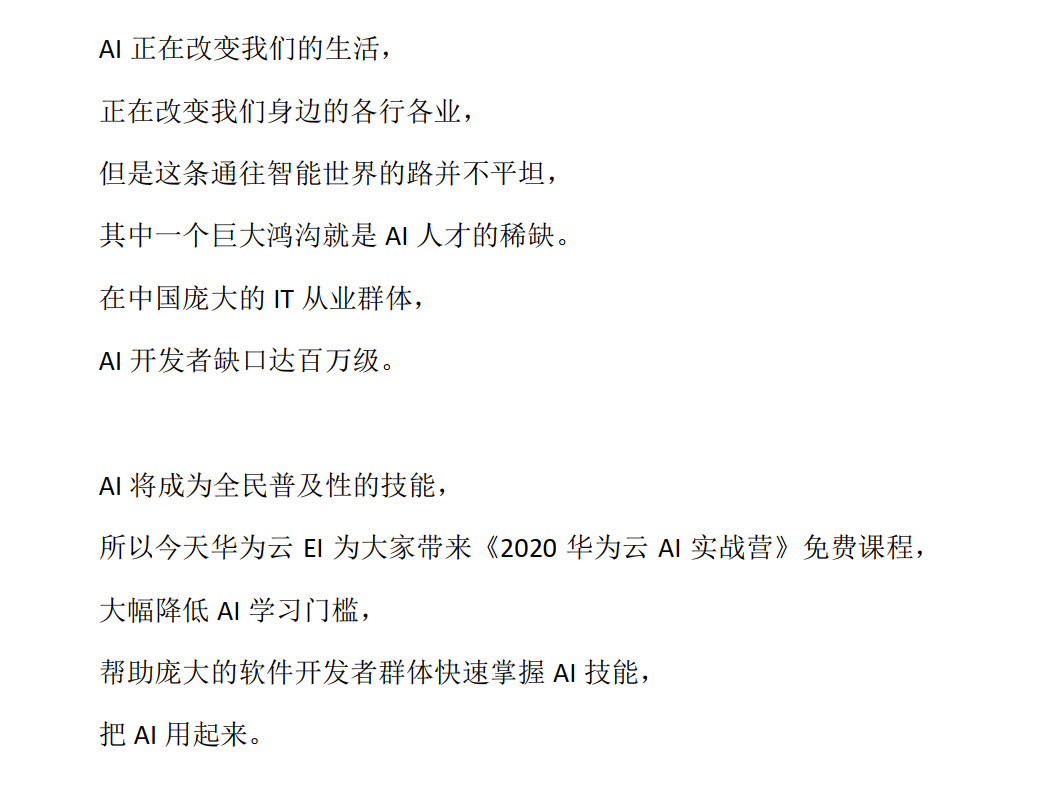

In [10]:
img = Image.open('./E2E_ocr/test_dataset/text.png')
img

### 10. 开始图片测试

In [11]:
test_dir = './E2E_ocr/test_dataset'  # 待测试图片目录
save_results = True
output_dir = test_dir + '_output'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
ocr_results = OrderedDict()
files = os.listdir(test_dir)
for file_name in files:
    if not (file_name.endswith('jpg') or file_name.endswith('png')
         or file_name.endswith('JPG') or file_name.endswith('PNG')):
            continue
    print(file_name, 'ocr result:')
    file_path = os.path.join(test_dir, file_name)
    
    img, boxes = ctpn_text_detection(file_path)  # step1, 检测文字位置
    sorted_boxes = sorted(boxes.tolist(), key = lambda x: (x[1], x[0]))  # step2, 对文字框进行排序，优先按文字框左上顶点的y坐标升序排序，其次按x坐标升序排序
    for index, box in enumerate(sorted_boxes):
        cut_text_img, _ = img_transform_perspective(img, box[:8])  # step3, 从原图上切割出各个文字块，并将倾斜的文字块变换为水平矩形文字块
        ocr_result = crnn_ocr(Image.fromarray(cut_text_img))  # step4, 对每个文字块进行字符识别
        ocr_results[str(index)] = ocr_result
        print(str(index) + ',', ocr_result)
        
        if save_results:
            draw_img = img[:, :, ::-1].copy()
            for i, box in enumerate(boxes):
                cv2.polylines(draw_img, [box[:8].astype(np.int32).reshape((-1, 1, 2))], True, color=(0, 0, 255), thickness=2)
            cv2.imwrite(os.path.join(output_dir, file_name), draw_img)
            #将输出结果转为json格式
            with codecs.open(os.path.join(output_dir, file_name.split('.')[0] + '.json'), 'w', 'utf-8') as f:
                json.dump(ocr_results, f, indent=4, ensure_ascii=False)
print('end')

text.png ocr result:
0, A1正在改变我们的生活，
1, 正在改变我们身边的各行各业，
2, 但是这条通往智能世界的路并不平坦，
3, 其中一个巨大鸿沟就是AI人才的稀缺。
4, 在中国庞大的I从业群体，
5, A开发者缺口达百万级。
6, A1将成为全民普及性的技能，
7, 所以今天华为云El为大家带来《2020华为云AI实战营》免费课程，
8, 大幅降低A1拳习门]椤，
9, 帮助庞大的软件开发者群体快速拳握A1技能，
10, 把AI用起来。
end
